# Example code for evaluating the coprecessing waveform model 
londonl@mit.edu / pilondon2@gmail.com 2020

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"


In [2]:
# Display basic info about calibration runs
scsearch( catalog=pwca_catalog, verbose=True );

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found verbose (=True) keyword.
## Found 40 possibly degenerate simulations:
[0001][hogshead] q8precessing: 1chi0.80-p-q8.00	(q8a08t120dP2_r03_T_96_360)
[0002][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t60D_dPm1)
[0003][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t90dPm1D_T_96_384)
[0004][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t120dPp1_T_96_360)
[0005][hogshead] q8precessing: 1chi0.40-p-q8.00	(q8a04t90dP0_T_96_360)
[0006][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th150)
[0007][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th120)
[0008][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th90)
[0009][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th60)
[0010][hogshead] chinmay_precessingRuns: 1chi0.80-p-q2.00	(q2_a10_a28_ph0_th30)
[0011][hogshead] q8: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)
[0012][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t30dPm5p5dRm4

## Compare NR calibration data and model

(scsearch)>> Found catalog (=...) keyword.
(scsearch)>> Found keyword (=q4a04t60dPm1.5D_T_96_360) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q4: 1chi0.40-p-q4.00	(q4a04t60dPm1.5D_T_96_360)



Text(0,1,'q4a04t60dPm1.5D_T_96_360')

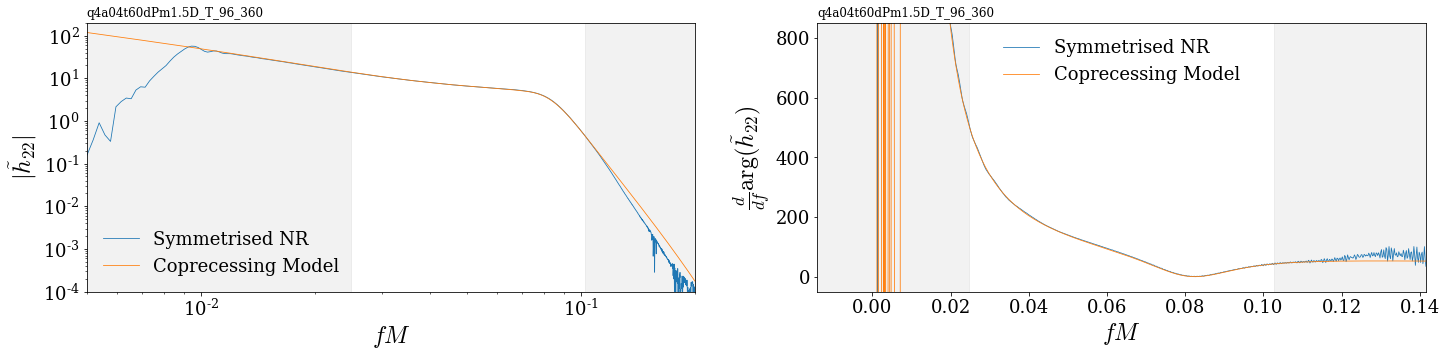

In [3]:

# Select single simulation based on name
a = scsearch( catalog=pwca_catalog, keyword='q4a04t60dPm1.5D_T_96_360', verbose=True )[0];

# Define data location
datadir = parent(pwca.__path__[0])+'data/version2/'

# Load select waveform data
files = glob( datadir+'q*.txt' )
simnames = [ f_.split('/')[-1].split('.t')[0] for f_ in files ]

# Find index corresponding to chosen case
k = simnames.index( a.simname )

# Load data for this case
raw_data = loadtxt(files[k]).T
data,_,fmin,fmax,fknot = determine_data_fitting_region(raw_data)

# Unpack raw (symmetrised) NR data
raw_f,raw_amp_td,raw_amp_fd,raw_dphi_td,raw_dphi_fd = raw_data

# create mask to select positive frequencies
raw_positive_mask = raw_f>0
raw_fp = f_ = raw_f[raw_positive_mask]

# ------------------------------------------------ #
# Generate a coprecessing waveform as 1D array
h22 = generate_pwca_waveform( f_, a.m1, a.m2, a.X1, a.X2, a.L )
# ------------------------------------------------ #

#
nr_amp     = raw_amp_fd[raw_positive_mask]
model_amp  = abs(h22)
nr_dphi    = raw_dphi_td[raw_positive_mask]
# -- NOTE -- the minus sign here is to place data in consistent conventions
model_dphi = spline_diff( f_, -unwrap(angle(h22)) )

#
calibration_mask    = (f_ >= fmin) & (f_ <= fmax)
adjusted_nr_dphi    = nr_dphi    - min(   nr_dphi[calibration_mask])
adjusted_model_dphi = model_dphi - min(model_dphi[calibration_mask])

#
figure( figsize=1.5*figaspect(0.618/3) )

# Compare model amplitude to NR
# --
subplot(1,2,1)
plot( f_, nr_amp, label='Symmetrised NR' )
plot( f_, model_amp, label='Coprecessing Model' )
yscale('log')
xscale('log')
ylim( 1e-4, 2e2 )
xlim(0.005,0.2)
axvspan( min(xlim()), fmin, alpha=0.05, color='k')
axvspan( fmax, max(xlim()), alpha=0.05, color='k')
legend()

ylabel(r'$|\tilde{h}_{22}|$')
xlabel('$fM$')
title(a.simname,loc='left',size=12)

# Compare model phase derivative to NR
# --
subplot(1,2,2)
plot( f_, adjusted_nr_dphi, label='Symmetrised NR' )
plot( f_, adjusted_model_dphi, label='Coprecessing Model' )
ylim(lim(adjusted_model_dphi[calibration_mask],dilate=0.1)+array([0,300]))
xlim(lim([fmin,fmax],dilate=0.5))
axvspan( min(xlim()), fmin, alpha=0.05, color='k')
axvspan( fmax, max(xlim()), alpha=0.05, color='k')
legend()

ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
xlabel('$fM$')
title(a.simname,loc='left',size=12)


## Plot time domain model waveform

>> The total time needed for the waveform is 6194.66
>> The total time provided for the waveform is 20000
>> shift = 66.232163
t_start = -1305.069137
>> The time domain waveform has a peak at index 38762 of 40000


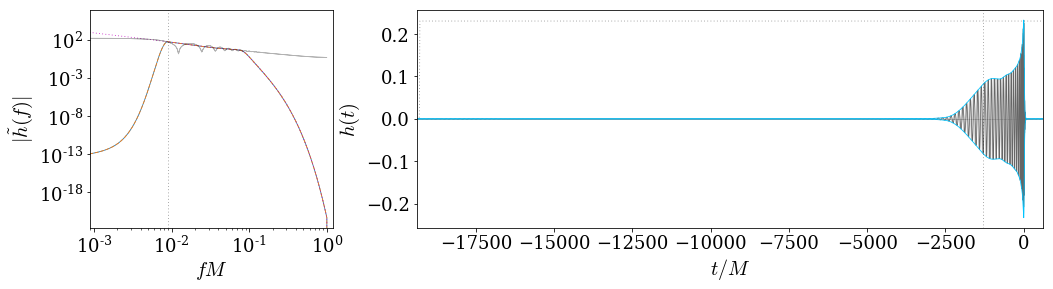

In [38]:
model_data = ( f_, abs(h22), unwrap(angle(h22)) )
# Use function in positive.physics
ht,t,_ = phenom2td( 0.009, 40000, 0.5, model_data,plot=True, fmax=0.6, verbose=True )

(-600, 200)

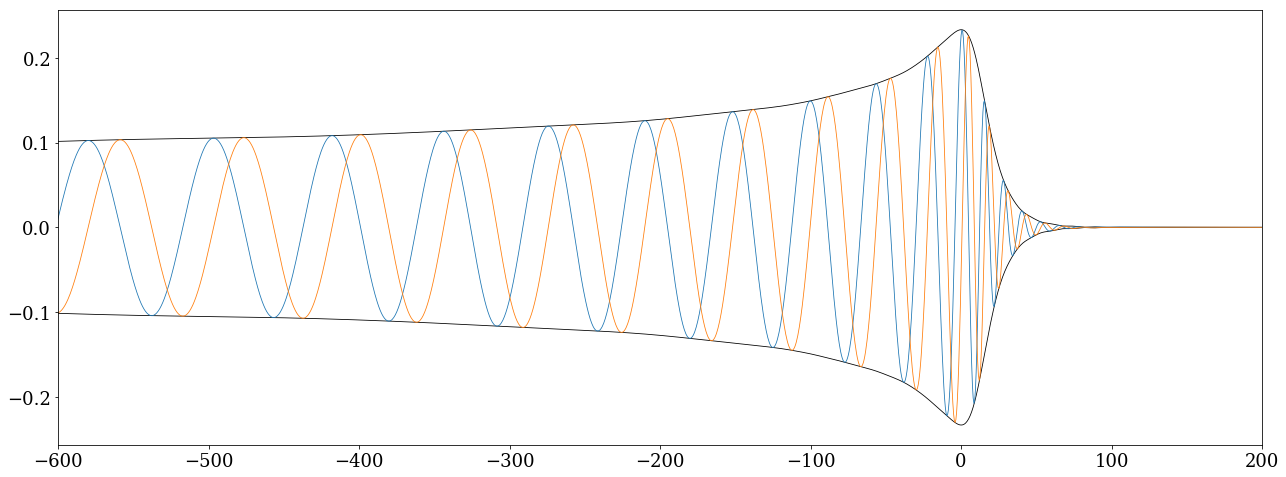

In [49]:

figure( figsize=2*figaspect(0.618*0.6) )

plot( t, abs(ht), color='k' )
plot( t,-abs(ht), color='k' )
plot( t, ht.real )
plot( t, ht.imag )
xlim(-600,200)

In [21]:
len(ht)

10597